# Temporal Linear Network (TLN) for VWAP prediction

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import keras
from tln import TLN

In [4]:
# Suppress TensorFlow warnings for cleaner output
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

### Step 1: Data loading and initial prep

In [6]:
# Load the dataset
df = pd.read_csv('../META_1min_firstratedata.csv')

# Convert timestamp and set as index
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['avg_price'] = (df['high'] + df['low']) / 2
df.set_index('timestamp', inplace=True)

# Filter for standard trading hours (9:30 AM - 4:00 PM)
trading_hours_df = df.between_time('09:30', '16:00').copy()

### Step 2: split data into training and testing sets

In [8]:
# Get unique dates
dates = df.index.normalize().unique()

# Split dates
train_dates = dates[:int(len(dates) * 0.75)]

# Create masks
mask = df.index.normalize().isin(train_dates)
train_df = df[mask].copy()
test_df = df[~mask].copy()

### Step 3: prepare data for TLN model

In [9]:
def create_tln_sequences(df, lookback_window, horizon):
    """
    Creates sequences of data for training the TLN model.
    X: Input features (lookback_window minutes of price and volume).
    y: Target data (horizon minutes of price and market volume for loss calculation).
    """

    features = ['avg_price', 'volume']
    X, y = [], []

    # Group by day to create sequences within each trading day
    daily_groups = df.groupby(df.index.date)
    
    for date, group in daily_groups:
        feature_data = group[features].values
        price_volume_data = group[['avg_price', 'volume']].values
        
        if len(feature_data) < lookback_window + horizon:
            continue
            
        for i in range(len(feature_data) - lookback_window - horizon + 1):
            X.append(feature_data[i : i + lookback_window])
            y.append(price_volume_data[i + lookback_window : i + lookback_window + horizon])
            
    return np.array(X), np.array(y)


### Define model parameters

In [10]:
LOOKBACK = 120  # Use the past 120 minutes of data
HORIZON = 30    # To predict the execution schedule for the next 30 minutes
FEATURES = ['avg_price', 'volume']
NUM_FEATURES = len(FEATURES)

In [11]:
# Create training and testing sequences
print("\nCreating TLN sequences...")
X_train, y_train = create_tln_sequences(train_df, LOOKBACK, HORIZON)
X_test, y_test = create_tln_sequences(test_df, LOOKBACK, HORIZON)

print(f"Training data shape: X_train -> {X_train.shape}, y_train -> {y_train.shape}")
print(f"Testing data shape: X_test -> {X_test.shape}, y_test -> {y_test.shape}")


Creating TLN sequences...
Training data shape: X_train -> (94911, 120, 2), y_train -> (94911, 30, 2)
Testing data shape: X_test -> (29969, 120, 2), y_test -> (29969, 30, 2)


### Step 4: define custom vwap loss function and TLN model

In [13]:
def vwap_loss(y_true, y_pred):
    """
    Custom Keras loss function to minimize the quadratic VWAP slippage.
    The model predicts the allocation schedule (y_pred).
    y_true contains the actual market prices and volumes needed to calculate the benchmark.
    """
    
    # Extract future prices and market volumes from y_true
    future_prices = y_true[:, :, 0]
    market_volumes = y_true[:, :, 1]

    # Calculate the VWAP achieved by the model's predicted schedule
    model_trade_value = keras.ops.sum(y_pred * future_prices, axis=1)
    model_total_shares = keras.ops.sum(y_pred, axis=1)
    model_vwap = model_trade_value / (model_total_shares + 1e-8) # Add epsilon for stability

    # Calculate the benchmark VWAP using market volumes
    benchmark_trade_value = keras.ops.sum(market_volumes * future_prices, axis=1)
    benchmark_total_volume = keras.ops.sum(market_volumes, axis=1)
    benchmark_vwap = benchmark_trade_value / (benchmark_total_volume + 1e-8)

    # The loss is the squared difference between the two VWAPs (slippage)
    slippage = model_vwap - benchmark_vwap
    return keras.ops.square(slippage)

In [14]:
# Define the TLN model architecture
# The model's output is an allocation schedule, ensured by the softmax activation[7]
tln_model = keras.Sequential([
    keras.Input(shape=(LOOKBACK, NUM_FEATURES)),
    TLN(
        output_len=HORIZON,
        output_features=1, # The model will internally produce one value per timestamp
        hidden_layers=2,
        use_convolution=True
    ),
    keras.layers.Flatten(),
    # The final Dense layer ensures the output matches the horizon length
    keras.layers.Dense(HORIZON, activation='softmax') 
])

In [16]:
# Compile the model with our custom loss function
tln_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=vwap_loss)
tln_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tln (TLN)                       │ (None, 30, 1)          │         5,414 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30)             │           930 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,344 (24.78 KB)

 Trainable params: 6,344 (24.78 KB)

 Non-trainable params: 0 (0.00 B)

### Step 5: Train the TLN Model

In [17]:
print("\nTraining the TLN model...")
history = tln_model.fit(
    X_train,
    y_train,
    epochs=20,  # A smaller number of epochs is often sufficient with a direct loss function
    batch_size=64,
    validation_split=0.2,
    verbose=1
)


Training the TLN model...
Epoch 1/20
1187/1187 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1179 - val_loss: 0.0233
Epoch 2/20
1187/1187 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0193 - val_loss: 0.0233
Epoch 3/20
1187/1187 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0201 - val_loss: 0.0237
Epoch 4/20
1187/1187 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0207 - val_loss: 0.0231
Epoch 5/20
1187/1187 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0181 - val_loss: 0.0227
Epoch 6/20
1187/1187 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0206 - val_loss: 0.0226
Epoch 7/20
1187/1187 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0204 - val_loss: 0.0224
Epoch 8/20
1187/1187 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0189 - val_loss: 0.0225
Epoch 9/20
1187/1187 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0190 - val_loss: 0.0222
Epoch 10/20
1187/1187 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0188 - val_loss: 0.0228
Epoch 11/20
1187/1187 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0189 - val_loss: 0.0224
Epo

### Step 6: backtesting and evaluation with trained TLN model

In [19]:
def calculate_benchmark_vwap(daily_df):
    """Calculates the true market VWAP for a given day."""
    if daily_df.empty or daily_df['volume'].sum() == 0:
        return np.nan
    return (daily_df['avg_price'] * daily_df['volume']).sum() / daily_df['volume'].sum()

In [20]:
def evaluate_tln_strategy(test_df, model, total_shares_to_trade=1_000_000):
    """
    Backtests the trained TLN model on the test data.
    """
    daily_groups = test_df.groupby(test_df.index.date)
    results = []

    for date, day_data in daily_groups:
        if len(day_data) < LOOKBACK + HORIZON:
            continue

        benchmark_vwap = calculate_benchmark_vwap(day_data)
        if pd.isna(benchmark_vwap):
            continue

        # Simulate trading for the day
        total_value_of_trades = 0
        total_shares_traded = 0
        
        # We trade from the first possible moment until the end of the day
        for i in range(len(day_data) - LOOKBACK):
            # Prepare the input sequence for the model
            input_sequence = day_data[i : i + LOOKBACK][FEATURES].values
            input_sequence = np.expand_dims(input_sequence, axis=0) # Add batch dimension

            # Predict the allocation schedule for the next HORIZON minutes
            predicted_schedule = model.predict(input_sequence, verbose=0)[0]
            
            # Determine shares to trade in the next minute based on the schedule
            # We only execute the first step of the horizon prediction
            shares_to_trade_next_minute = predicted_schedule[0] * total_shares_to_trade
            
            # Get the price for the trade
            execution_price = day_data.iloc[i + LOOKBACK]['avg_price']
            
            # Accumulate trade value and shares
            total_value_of_trades += shares_to_trade_next_minute * execution_price
            total_shares_traded += shares_to_trade_next_minute

        if total_shares_traded == 0:
            continue

        model_vwap = total_value_of_trades / total_shares_traded
        
        # Calculate slippage
        slippage = model_vwap - benchmark_vwap
        slippage_bps = (slippage / benchmark_vwap) * 10000  # in basis points

        results.append({
            'date': date,
            'benchmark_vwap': benchmark_vwap,
            'model_vwap': model_vwap,
            'slippage': slippage,
            'slippage_bps': slippage_bps
        })
        
    return pd.DataFrame(results)

### Step 7: run evaluation and display results

In [22]:
print("\nEvaluating TLN model performance on the test set...")
results_df = evaluate_tln_strategy(test_df, tln_model)


Evaluating TLN model performance on the test set...


In [33]:
results_df

,benchmark_vwap,model_vwap,slippage,slippage_bps
date,,,,
2023-07-03,286.620064,286.182777,-0.437287,-15.256689
2023-07-05,294.702689,295.056704,0.354015,12.012631
2023-07-06,294.375084,293.817955,-0.557129,-18.925837
2023-07-07,292.016067,292.024894,0.008827,0.302278
2023-07-10,292.544818,292.228996,-0.315821,-10.795658
...,...,...,...,...
2023-09-25,298.430516,299.197719,0.767204,25.707955
2023-09-26,298.468219,298.643792,0.175573,5.882481
2023-09-27,296.075869,297.828514,1.752646,59.195832



--- TLN Model Performance Summary ---
Average Slippage: 1.99 bps
Standard Deviation of Slippage: 21.44 bps
Number of Days Tested: 63

--- First 5 Days of Results ---
            benchmark_vwap  model_vwap  slippage  slippage_bps
date                                                          
2023-07-03      286.620064  286.182777 -0.437287    -15.256689
2023-07-05      294.702689  295.056704  0.354015     12.012631
2023-07-06      294.375084  293.817955 -0.557129    -18.925837
2023-07-07      292.016067  292.024894  0.008827      0.302278
2023-07-10      292.544818  292.228996 -0.315821    -10.795658


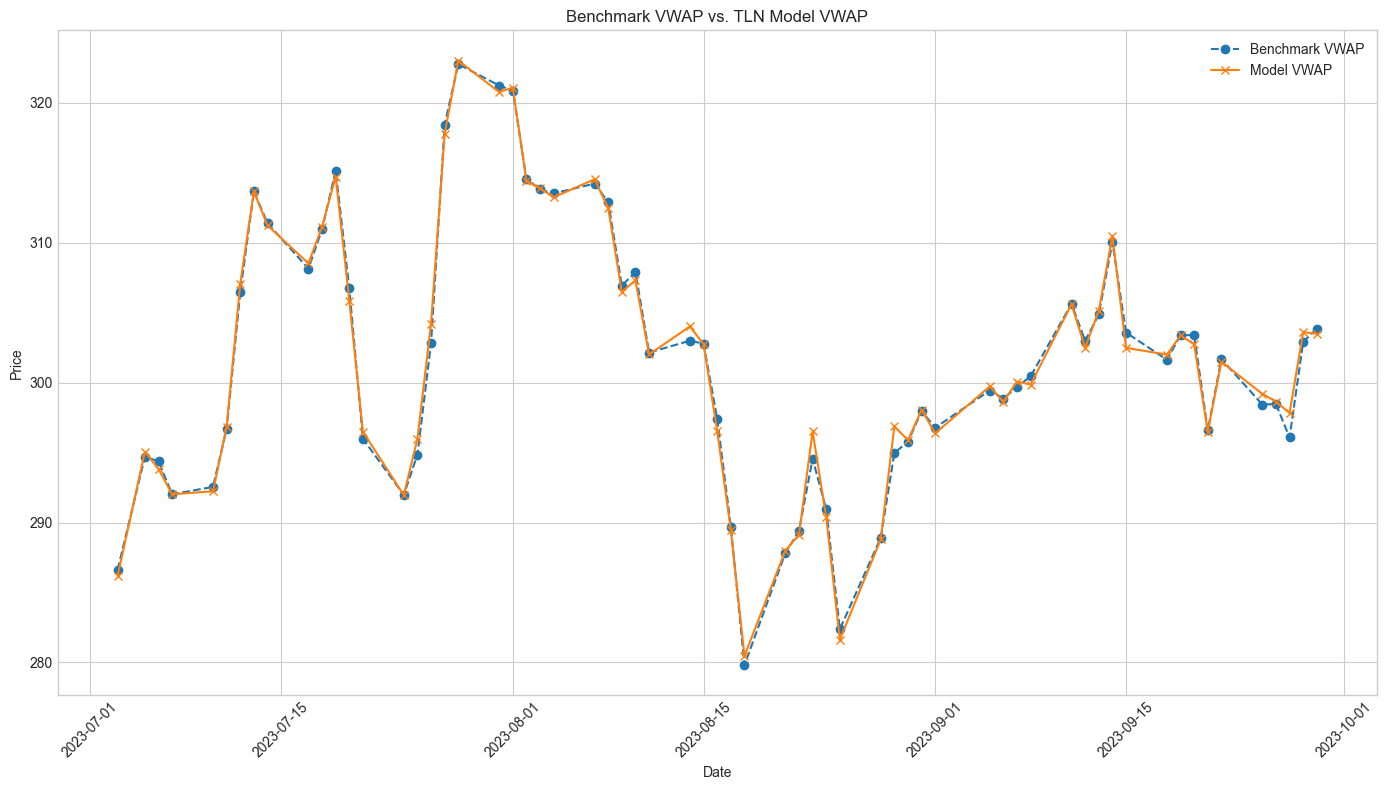

In [34]:
# Perform calculations
avg_slippage_bps = results_df['slippage_bps'].mean()
std_slippage_bps = results_df['slippage_bps'].std()

# Print summary
print(f"\n--- TLN Model Performance Summary ---")
print(f"Average Slippage: {avg_slippage_bps:.2f} bps")
print(f"Standard Deviation of Slippage: {std_slippage_bps:.2f} bps")
print(f"Number of Days Tested: {len(results_df)}")
print("\n--- First 5 Days of Results ---")
print(results_df.head())

# Plot the results
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(14, 8))
plt.plot(results_df.index, results_df['benchmark_vwap'], label='Benchmark VWAP', marker='o', linestyle='--')
plt.plot(results_df.index, results_df['model_vwap'], label='Model VWAP', marker='x', linestyle='-')
plt.title('Benchmark VWAP vs. TLN Model VWAP')
plt.ylabel('Price')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [35]:
output_file = 'results/vwap_model_predictions_02_TLN.csv'
test_df.to_csv(output_file, index=True)
print(f"Test results saved to {output_file}")

Test results saved to results/vwap_model_predictions_02_TLN.csv
